In [1]:
import pandas as pd
import numpy as np
import re
from IPython.display import Image, display, Markdown, HTML
%matplotlib inline

# HTML version: jupyter nbconvert read_model.ipynb --to html --TemplateExporter.exclude_input=True

In [2]:
infile = "../pyCIMS_model_description.xlsm"

NODE_COL = "Node"
MODEL_SHEET = "Model"
# TODO extract other string constants used below and place them in some constants here

mxl = pd.read_excel(infile, sheet_name=None, header=1)
mdf0 = mxl[MODEL_SHEET].replace({pd.np.nan: None})
mdf0.index += 3  # adjust index to correspond to Excel line numbers (+1: 0 vs 1 origin, +1: header skip, +1: column headers)

In [3]:
display(Markdown("""
# pyCIMS model reader

The code here reads [{}]({}) and extracts the '{}' sheet into a Pandas DataFrame.
The dataframe is then split and the referenced parts are organized in dictionaries, see below.

Later, the individual node and tech frames are analyzed for service connectivity information, 
enabling the construction of a graph.
""".format(infile, infile, MODEL_SHEET)))


# pyCIMS model reader

The code here reads [../pyCIMS_model_description.xlsm](../pyCIMS_model_description.xlsm) and extracts the 'Model' sheet into a Pandas DataFrame.
The dataframe is then split and the referenced parts are organized in dictionaries, see below.

Later, the individual node and tech frames are analyzed for service connectivity information, 
enabling the construction of a graph.


In [4]:
# DataFrame helpers
def display_df(df):
    """Display None as blanks"""
    df = pd.DataFrame(df)
    if not df.empty:
        display(pd.DataFrame(df).replace({None: ''}))
def non_empty_rows(df, exclude_column="Node"):
    """Return bool array to flag rows as False that have only None or False values, ignoring exclude_column"""
    return df.loc[:, df.columns != exclude_column].T.apply(any)

# column extraction helpers
re_year = re.compile(r'^[0-9]{4}$')
def is_year(cn):
    """Check if input int or str is 4 digits [0-9] between begin ^ and end $ of string"""
    # unit test: assert is_year, 1900
    return bool(re_year.match(str(cn)))
def find_first(items, pred=bool, default=None):
    """Find first item for that pred is True"""
    return next(filter(pred, items), default)
def find_first_index(items, pred=bool):
    """Find index of first item for that pred is True"""
    return find_first(enumerate(items), lambda kcn: pred(kcn[1]))[0]
def get_node_cols(mdf, first_data_col_name="Node"):
    """Returns list of column names after 'Node' and a list of years that follow """
    node_col_idx = find_first_index(mdf.columns,
                                    lambda cn: first_data_col_name.lower() in cn.lower())
    relevant_columns = mdf.columns[node_col_idx:]
    year_or_not = list(map(is_year, relevant_columns))
    first_year_idx = find_first_index(year_or_not)
    last_year_idx = find_first_index(year_or_not[first_year_idx:],
                                     lambda b: not b) + first_year_idx
    # list(...)[a:][:b] extracts b elements starting at a
    year_cols = mdf.columns[node_col_idx:][first_year_idx:last_year_idx]
    return mdf.columns[node_col_idx:][:first_year_idx], year_cols

In [5]:
node_cols, year_cols = get_node_cols(mdf0)
all_cols = np.concatenate((node_cols, year_cols))
mdf = mdf0.loc[1:,all_cols] # drop irrelevant columns and skip first, empty row

In [6]:
# display_df(mdf)

In [7]:
# determine, row ranges for each node def, based on non-empty Node field
node_rows = mdf.Node[~mdf.Node.isnull()] # does not work if node names have been filled in
node_rows.index.name = "Row Number"
last_row = mdf.index[-1]
node_start_ends = zip(node_rows.index,
                      node_rows.index[1:].tolist() + [last_row])

In [8]:
# extract Node DataFrames, at this point still including Technologies
node_dfs = {}
non_node_cols = mdf.columns != NODE_COL
for s, e in node_start_ends:
    node_name = mdf.Node[s]
    node_df = mdf.loc[s+1:e-1]
    node_df = node_df.loc[non_empty_rows(node_df), non_node_cols]
    # mdf.loc[s+1:e-1, "Node"] = node_name
    node_dfs[node_name] = node_df
# len(node_dfs)

In [9]:
## intermediate output for dev purposes
# for nn, ndf in node_dfs.items():
#     display(Markdown("Node: **{}**".format(nn)))
#     display_df(ndf)

In [10]:
# Extract tech dfs from node df's and rewrite node df without techs
tech_dfs = {}
for nn, ndf in node_dfs.items():
    if any(ndf.Parameter == "Technology"):
        tdfs = {}
        first_row, last_row = ndf.index[0], ndf.index[-1]
        tech_rows = ndf.loc[ndf.Parameter == "Technology"].index
        for trs, tre in zip(tech_rows, tech_rows[1:].tolist()+[last_row]):
            tech_df = ndf.loc[trs:tre-1]
            tech_name = tech_df.iloc[0].Value
            tdfs[tech_name] = tech_df
        tech_dfs[nn] = tdfs
        node_dfs[nn] = ndf.loc[:tech_rows[0]-1]

# Display Nodes and Technologies
`node_dfs` contains a dictionary giving the DataFrames that hold the relevant rows for each node, without Technology info  
`tech_dfs` contains a dictionary for each node naming the technologies and holding the relevant rows in a DF

In [11]:
# display content of entire Model dataframe as separate df's
for nn, ndf in node_dfs.items():
    display(Markdown("Node: **{}**".format(nn)))
    display_df(ndf)
    if nn in tech_dfs:
        for tech_name, tdf in tech_dfs[nn].items():
            display(Markdown("Node / Technology: **{} / {}**".format(nn, tech_name)))
            display_df(tdf)

Node: **Simulation**

,Parameter,Branch,Unit,Value,2000,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050
5,Simulation Time,,Years,,2000.0,2005.0,2010.0,2015.0,2020.0,2025.0,2030.0,,,,


Node: **Canada**

,Parameter,Branch,Unit,Value,2000,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050
8,Service supply,Canada,,,,,,,,,,,,,
9,Competition type,,,Fixed Ratio,,,,,,,,,,,
10,Service demand,Canada.Alberta,,,1,1,1,1,1,1,1,1,1,1,1


Node: **Alberta**

,Parameter,Branch,Unit,Value,2000,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050
13,Service supply,Canada.Alberta,person,Population,3.0042e+06,3.32177e+06,3.73208e+06,4.14449e+06,4.4728e+06,4.9085e+06,5.3605e+06,5.83e+06,6.3178e+06,6.54679e+06,6.76988e+06
14,Service supply,Canada.Alberta,2015$ billion,GDP,217.724,263.911,283.544,337.59,374.179,404.742,441.256,484.097,532.616,586.751,646.121
15,Competition type,,,Fixed Ratio,,,,,,,,,,,
16,Service demand,Canada.Alberta.Residential,household/person,Residential,0.384615,0.384615,0.384615,0.384615,0.384615,0.384615,0.384615,0.384615,0.384615,0.384615,0.384615


Node: **Residential**

,Parameter,Branch,Unit,Value,2000,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050
19,Service supply,Canada.Alberta.Residential,household,Residential,,,,,,,,,,,
20,Competition type,,,Fixed Ratio,,,,,,,,,,,
21,Price,,2015$/GJ,Diesel,19,25,29,32,32.64,33.2928,33.9587,34.6378,35.3306,36.0372,36.7579
22,Price,,2015$/GJ,Light Fuel Oil,20,26,30,33,33.66,34.3332,35.0199,35.7203,36.4347,37.1634,37.9066
23,Price,,2015$/GJ,Natural Gas,11.52,11.52,11.52,11.52,11.52,11.52,11.52,11.52,11.52,11.52,11.52
24,Price,,2015$/GJ,Electricity,22,,,,,,,,,,
25,Price,,2015$/GJ,Wood,12,12,12,12,12.24,12.4848,12.7345,12.9892,13.249,13.5139,13.7842
26,Price,,2015$/tCO2,CO2,0,0,0,0,20,50,70,70,70,70,70
27,Price,,2015$/tCO2,CH4,0,0,0,0,0,0,0,0,0,0,0
28,Price,,2015$/tCO2,N2O,0,0,0,0,0,0,0,0,0,0,0


Node: **Buildings**

,Parameter,Branch,Unit,Value,2000,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050
32,Service supply,Canada.Alberta.Residential.Buildings,building,Buildings,,,,,,,,,,,
33,Competition type,,,Fixed Market Shares,,,,,,,,,,,
34,Market share,,%,Single Family Detached,0.719409,0.7195,0.719,0.7185,0.718,0.7175,0.717,0.7165,0.716,0.7155,0.715
35,Market share,,%,Single Family Attached,0.1,0.101,0.102,0.103,0.104,0.105,0.106,0.107,0.108,0.109,0.11
36,Market share,,%,Apartment,0.14,0.1395,0.139,0.1385,0.138,0.1375,0.137,0.1365,0.136,0.1355,0.135
37,Market share,,%,Mobile,0.0405908,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04
38,Service demand,Canada.Alberta.Residential.Buildings.Shell,m2 floorspace/building,Single Family Detached,138.517,141.02,143.955,146.245,146.683,146.683,146.683,146.683,146.683,146.683,146.683
39,Service demand,Canada.Alberta.Residential.Buildings.Shell,m2 floorspace/building,Single Family Attached,107.366,111.231,115.914,121.533,122.609,122.609,122.609,122.609,122.609,122.609,122.609
40,Service demand,Canada.Alberta.Residential.Buildings.Shell,m2 floorspace/building,Apartment,84.7599,88.6872,92.968,97.1831,97.9311,97.9311,97.9311,97.9311,97.9311,97.9311,97.9311
41,Service demand,Canada.Alberta.Residential.Buildings.Shell,m2 floorspace/building,Mobile,91.7214,92.2624,93.4022,94.6889,95.038,95.038,95.038,95.038,95.038,95.038,95.038


Node: **Shell**

,Parameter,Branch,Unit,Value,2000,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050
52,Service supply,Canada.Alberta.Residential.Buildings.Shell,m2 floorspace,Shell,,,,,,,,,,,
53,Competition type,,,Tech Compete,,,,,,,,,,,
54,Heterogeneity,,,v,10,,,,,,,,,,


Node / Technology: **Shell / Pre-1960**

,Parameter,Branch,Unit,Value,2000,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050
55,Technology,,,Pre-1960,,,,,,,,,,,
56,Available,,Date,Pre-1960,1990,,,,,,,,,,
57,Unavailable,,Date,Pre-1960,2000,,,,,,,,,,
58,Lifetime,,Years,Pre-1960,25,,,,,,,,,,
59,Financial discount rate,,%,Pre-1960,,,,,,,,,,,
60,Capital Cost,,2015$/m2 floorspace,Pre-1960,,,,,,,,,,,
61,Operating Cost,,2015$/m2 floorspace,Pre-1960,,,,,,,,,,,
62,Intangible Cost,,2015$/m2 floorspace,Pre-1960,,,,,,,,,,,
63,Market share total_Max,,%,Pre-1960,,,,,,,,,,,
64,Market share total_Min,,%,Pre-1960,,,,,,,,,,,


Node / Technology: **Shell / Post-1960**

,Parameter,Branch,Unit,Value,2000,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050
68,Technology,,,Post-1960,,,,,,,,,,,
69,Available,,Date,Post-1960,1990,,,,,,,,,,
70,Unavailable,,Date,Post-1960,2000,,,,,,,,,,
71,Lifetime,,Years,Post-1960,25,,,,,,,,,,
72,Financial discount rate,,%,Post-1960,0.25,,,,,,,,,,
73,Capital Cost,,2015$/m2 floorspace,Post-1960,,,,,,,,,,,
74,Operating Cost,,2015$/m2 floorspace,Post-1960,,,,,,,,,,,
75,Intangible Cost,,2015$/m2 floorspace,Post-1960,,,,,,,,,,,
76,Market share total_Max,,%,Post-1960,,,,,,,,,,,
77,Market share total_Min,,%,Post-1960,,,,,,,,,,,


Node / Technology: **Shell / Standard**

,Parameter,Branch,Unit,Value,2000,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050
81,Technology,,,Standard,,,,,,,,,,,
82,Available,,Date,Standard,2000,,,,,,,,,,
83,Unavailable,,Date,Standard,2100,,,,,,,,,,
84,Lifetime,,Years,Standard,25,,,,,,,,,,
85,Financial discount rate,,%,Standard,0.25,,,,,,,,,,
86,Capital Cost,,2015$/m2 floorspace,Standard,2655,2655,2655,2655,2655,2655,2655,2655,2655,2655,2655
87,Operating Cost,,2015$/m2 floorspace,Standard,,,,,,,,,,,
88,Intangible Cost,,2015$/m2 floorspace,Standard,,,,,,,,,,,
89,Market share total_Max,,%,Standard,,,,,,,,,,,
90,Market share total_Min,,%,Standard,,,,,,,,,,,


Node / Technology: **Shell / R2000**

,Parameter,Branch,Unit,Value,2000,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050
94,Technology,,,R2000,,,,,,,,,,,
95,Available,,Date,R2000,2000,,,,,,,,,,
96,Unavailable,,Date,R2000,2100,,,,,,,,,,
97,Lifetime,,Years,R2000,25,,,,,,,,,,
98,Financial discount rate,,%,R2000,0.25,,,,,,,,,,
99,Capital Cost,,2015$/m2 floorspace,R2000,10548,10548,10548,10548,10548,10548,10548,10548,10548,10548,10548
100,Operating Cost,,2015$/m2 floorspace,R2000,,,,,,,,,,,
101,Intangible Cost,,2015$/m2 floorspace,R2000,,,,,,,,,,,
102,Market share total_Max,,%,R2000,,,,,,,,,,,
103,Market share total_Min,,%,R2000,,,,,,,,,,,


Node / Technology: **Shell / LEED**

,Parameter,Branch,Unit,Value,2000,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050
107,Technology,,,LEED,,,,,,,,,,,
108,Available,,Date,LEED,2015,,,,,,,,,,
109,Unavailable,,Date,LEED,2100,,,,,,,,,,
110,Lifetime,,Years,LEED,25,,,,,,,,,,
111,Financial discount rate,,%,LEED,0.25,,,,,,,,,,
112,Capital Cost,,2015$/m2 floorspace,LEED,18325,18325,18325,18325,18325,18325,18325,18325,18325,18325,18325
113,Operating Cost,,2015$/m2 floorspace,LEED,,,,,,,,,,,
114,Intangible Cost,,2015$/m2 floorspace,LEED,,,,,,,,,,,
115,Market share total_Max,,%,LEED,,,,,,,,,,,
116,Market share total_Min,,%,LEED,,,,,,,,,,,


Node: **Space heating**

,Parameter,Branch,Unit,Value,2000,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050
122,Service supply,Canada.Alberta.Residential.Buildings.Shell.Spa...,,GJ,,,,,,,,,,,
123,Competition type,,,Tech Compete,,,,,,,,,,,
124,Heterogeneity,,,v,10,,,,,,,,,,


Node / Technology: **Space heating / Electric baseboard**

,Parameter,Branch,Unit,Value,2000,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050
125,Technology,,,Electric baseboard,,,,,,,,,,,
126,Available,,Date,Electric baseboard,2000,,,,,,,,,,
127,Unavailable,,Date,Electric baseboard,2100,,,,,,,,,,
128,Lifetime,,Years,Electric baseboard,25,,,,,,,,,,
129,Financial discount rate,,%,Electric baseboard,0.25,,,,,,,,,,
130,Capital Cost,,2015$/GJ,Electric baseboard,2655,2655,2655,2655,2655,2655,2655,2655,2655,2655,2655
131,Operating Cost,,2015$/GJ,Electric baseboard,,,,,,,,,,,
132,Intangible Cost,,2015$/GJ,Electric baseboard,,,,,,,,,,,
133,Service Cost,Canada.Alberta.Electricity,2015$/GJ,Electric baseboard,22,,,,,,,,,,
134,Market share total_Max,,%,Electric baseboard,,,,,,,,,,,


Node / Technology: **Space heating / Furnace**

,Parameter,Branch,Unit,Value,2000,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050
140,Technology,,,Furnace,,,,,,,,,,,
141,Available,,Date,Furnace,2000,,,,,,,,,,
142,Unavailable,,Date,Furnace,2100,,,,,,,,,,
143,Service Cost,Canada.Alberta.Residential.Buildings.Shell.Spa...,2015$/GJ,Furnace,503.291,,,,,,,,,,
144,Market share total_Max,,%,Furnace,,,,,,,,,,,
145,Market share total_Min,,%,Furnace,,,,,,,,,,,
146,Market share new_Max,,%,Furnace,,,,,,,,,,,
147,Market share new_Min,,%,Furnace,,,,,,,,,,,
148,Service demand,Canada.Alberta.Residential.Buildings.Shell.Spa...,GJ used / GJ provided,Furnace,1,1,1,1,1,1,1,1,1,1,1


Node: **Furnace**

,Parameter,Branch,Unit,Value,2000,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050
152,Service supply,Canada.Alberta.Residential.Furnace,,GJ,,,,,,,,,,,
153,Competition type,,,Tech Compete,,,,,,,,,,,
154,Heterogeneity,,,v,10,,,,,,,,,,
155,Social discount rate,,%,r,0.25,,,,,,,,,,


Node / Technology: **Furnace / Natural Gas_existing**

,Parameter,Branch,Unit,Value,2000,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050
156,Technology,,,Natural Gas_existing,,,,,,,,,,,
157,Available,,Date,Natural Gas_existing,2000,,,,,,,,,,
158,Unavailable,,Date,Natural Gas_existing,2000,,,,,,,,,,
159,Lifetime,,Years,Natural Gas_existing,18,,,,,,,,,,
160,Financial discount rate,,%,Natural Gas_existing,0.25,,,,,,,,,,
161,Capital Cost,,2015$/GJ,Natural Gas_existing,1782.5,1782.5,1782.5,1782.5,1782.5,1782.5,1782.5,1782.5,1782.5,1782.5,1782.5
162,Operating Cost,,2015$/GJ,Natural Gas_existing,,,,,,,,,,,
163,Intangible Cost,,2015$/GJ,Natural Gas_existing,,,,,,,,,,,
164,Service Cost,Canada.Alberta.Natural Gas,2015$/GJ,Natural Gas_existing,18.5818,,,,,,,,,,
165,Service demand,Canada.Alberta.Natural Gas,GJ used / GJ provided,Natural Gas_existing,1.613,1.613,1.613,1.613,1.613,1.613,1.613,1.613,1.613,1.613,1.613


Node / Technology: **Furnace / Heat pump_air source**

,Parameter,Branch,Unit,Value,2000,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050
167,Technology,,,Heat pump_air source,,,,,,,,,,,
168,Available,,Date,Heat pump_air source,2000,,,,,,,,,,
169,Unavailable,,Date,Heat pump_air source,2100,,,,,,,,,,
170,Lifetime,,Years,Heat pump_air source,12,,,,,,,,,,
171,Financial discount rate,,%,Heat pump_air source,0.25,,,,,,,,,,
172,Capital Cost,,2015$/GJ,Heat pump_air source,4886,4641.7,4409.61,4189.13,3979.68,3780.69,3591.66,3412.08,3241.47,3079.4,2925.43
173,Operating Cost,,2015$/GJ,Heat pump_air source,,,,,,,,,,,
174,Intangible Cost,,2015$/GJ,Heat pump_air source,,,,,,,,,,,
175,Service Cost,Canada.Alberta.Electricity,2015$/GJ,Heat pump_air source,11.572,,,,,,,,,,
176,Competition exclude,Canada.Alberta.Residential.Buildingss(Apartment),,Heat pump_air source,,,,,,,,,,,


Node / Technology: **Furnace / Heat pump_ground source**

,Parameter,Branch,Unit,Value,2000,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050
181,Technology,,,Heat pump_ground source,,,,,,,,,,,
182,Available,,Date,Heat pump_ground source,2010,,,,,,,,,,
183,Unavailable,,Date,Heat pump_ground source,2100,,,,,,,,,,
184,Lifetime,,Years,Heat pump_ground source,50,,,,,,,,,,
185,Financial discount rate,,%,Heat pump_ground source,0.25,,,,,,,,,,
186,Capital Cost,,2015$/GJ,Heat pump_ground source,15521,15521,15521,15521,15521,15521,15521,15521,15521,15521,15521
187,Operating Cost,,2015$/GJ,Heat pump_ground source,,,,,,,,,,,
188,Intangible Cost,,2015$/GJ,Heat pump_ground source,,,,,,,,,,,
189,Service Cost,Canada.Alberta.Electricity,2015$/GJ,Heat pump_ground source,8.8,,,,,,,,,,
190,Market share total_Max,,%,Heat pump_ground source,,,,,,,,,,,


Node / Technology: **Furnace / Natural Gas_high efficiency**

,Parameter,Branch,Unit,Value,2000,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050
194,Technology,,,Natural Gas_high efficiency,,,,,,,,,,,
195,Available,,Date,Natural Gas_high efficiency,2000,,,,,,,,,,
196,Unavailable,,Date,Natural Gas_high efficiency,2100,,,,,,,,,,
197,Lifetime,,Years,Natural Gas_high efficiency,18,,,,,,,,,,
198,Financial discount rate,,%,Natural Gas_high efficiency,0.25,,,,,,,,,,
199,Capital Cost,,2015$/GJ,Natural Gas_high efficiency,3565,3565,3565,3565,3565,3565,3565,3565,3565,3565,3565
200,Operating Cost,,2015$/GJ,Natural Gas_high efficiency,,,,,,,,,,,
201,Intangible Cost,,2015$/GJ,Natural Gas_high efficiency,,,,,,,,,,,
202,Service Cost,Canada.Alberta.Natural Gas,2015$/GJ,Natural Gas_high efficiency,12.7987,,,,,,,,,,
203,Market share total_Max,,%,Natural Gas_high efficiency,,,,,,,,,,,


Node: **Water heating**

,Parameter,Branch,Unit,Value,2000,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050
209,Service supply,Canada.Alberta.Residential.Buildings.Shell.Wat...,,GJ,,,,,,,,,,,
210,Competition type,,,Tech Compete,,,,,,,,,,,
211,Heterogeneity,,,v,10,,,,,,,,,,


Node / Technology: **Water heating / House_Natural Gas_existing stock**

,Parameter,Branch,Unit,Value,2000,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050
268,Technology,,,House_Natural Gas_existing stock,,,,,,,,,,,
269,Available,,Date,House_Natural Gas_existing stock,1990,,,,,,,,,,
270,Unavailable,,Date,House_Natural Gas_existing stock,2000,,,,,,,,,,
271,Lifetime,,Years,House_Natural Gas_existing stock,,,,,,,,,,,
272,Financial discount rate,,%,House_Natural Gas_existing stock,,,,,,,,,,,
273,Capital Cost,,2015$/GJ,House_Natural Gas_existing stock,,,,,,,,,,,
274,Operating Cost,,2015$/GJ,House_Natural Gas_existing stock,,,,,,,,,,,
275,Intangible Cost,,2015$/GJ,House_Natural Gas_existing stock,,,,,,,,,,,
276,Service Cost,,2015$/GJ,House_Natural Gas_existing stock,,,,,,,,,,,
277,Competition exclude,Canada.Alberta.Residential.Buildingss(Single F...,,House_Natural Gas_existing stock,,,,,,,,,,,


Node / Technology: **Water heating / House_Electric_existing stock**

,Parameter,Branch,Unit,Value,2000,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050
284,Technology,,,House_Electric_existing stock,,,,,,,,,,,
285,Available,,Date,House_Electric_existing stock,1990,,,,,,,,,,
286,Unavailable,,Date,House_Electric_existing stock,2000,,,,,,,,,,
287,Lifetime,,Years,House_Electric_existing stock,,,,,,,,,,,
288,Financial discount rate,,%,House_Electric_existing stock,,,,,,,,,,,
289,Capital Cost,,2015$/GJ,House_Electric_existing stock,,,,,,,,,,,
290,Operating Cost,,2015$/GJ,House_Electric_existing stock,,,,,,,,,,,
291,Intangible Cost,,2015$/GJ,House_Electric_existing stock,,,,,,,,,,,
292,Service Cost,,2015$/GJ,House_Electric_existing stock,,,,,,,,,,,
293,Competition exclude,Canada.Alberta.Residential.Buildingss(Single F...,,House_Electric_existing stock,,,,,,,,,,,


Node / Technology: **Water heating / House_Natural Gas_Standard**

,Parameter,Branch,Unit,Value,2000,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050
300,Technology,,,House_Natural Gas_Standard,,,,,,,,,,,
301,Available,,Date,House_Natural Gas_Standard,2000,,,,,,,,,,
302,Unavailable,,Date,House_Natural Gas_Standard,2020,,,,,,,,,,
303,Lifetime,,Years,House_Natural Gas_Standard,,,,,,,,,,,
304,Financial discount rate,,%,House_Natural Gas_Standard,,,,,,,,,,,
305,Capital Cost,,2015$/GJ,House_Natural Gas_Standard,,,,,,,,,,,
306,Operating Cost,,2015$/GJ,House_Natural Gas_Standard,,,,,,,,,,,
307,Intangible Cost,,2015$/GJ,House_Natural Gas_Standard,,,,,,,,,,,
308,Service Cost,,2015$/GJ,House_Natural Gas_Standard,,,,,,,,,,,
309,Competition exclude,Canada.Alberta.Residential.Buildingss(Single F...,,House_Natural Gas_Standard,,,,,,,,,,,


Node / Technology: **Water heating / House_Electric_Standard**

,Parameter,Branch,Unit,Value,2000,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050
316,Technology,,,House_Electric_Standard,,,,,,,,,,,
317,Available,,Date,House_Electric_Standard,2000,,,,,,,,,,
318,Unavailable,,Date,House_Electric_Standard,2020,,,,,,,,,,
319,Lifetime,,Years,House_Electric_Standard,,,,,,,,,,,
320,Financial discount rate,,%,House_Electric_Standard,,,,,,,,,,,
321,Capital Cost,,2015$/GJ,House_Electric_Standard,,,,,,,,,,,
322,Operating Cost,,2015$/GJ,House_Electric_Standard,,,,,,,,,,,
323,Intangible Cost,,2015$/GJ,House_Electric_Standard,,,,,,,,,,,
324,Service Cost,,2015$/GJ,House_Electric_Standard,,,,,,,,,,,
325,Competition exclude,Canada.Alberta.Residential.Buildingss(Single F...,,House_Electric_Standard,,,,,,,,,,,


Node: **Dishwashing**

,Parameter,Branch,Unit,Value,2000,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050
335,Service supply,Canada.Alberta.Residential.Buildings.Shell.Dis...,,GJ,,,,,,,,,,,
336,Competition type,,,Tech Compete,,,,,,,,,,,
337,Heterogeneity,,,v,10,,,,,,,,,,


Node / Technology: **Dishwashing / Electric baseboard**

,Parameter,Branch,Unit,Value,2000,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050
338,Technology,,,Electric baseboard,,,,,,,,,,,
339,Available,,Date,Electric baseboard,1990,,,,,,,,,,
340,Unavailable,,Date,Electric baseboard,2100,,,,,,,,,,
341,Lifetime,,Years,Electric baseboard,25,,,,,,,,,,
342,Financial discount rate,,%,Electric baseboard,0.25,,,,,,,,,,
343,Capital Cost,,2015$/GJ,Electric baseboard,15,,,,,,,,,,
344,Operating Cost,,2015$/GJ,Electric baseboard,,,,,,,,,,,
345,Intangible Cost,,2015$/GJ,Electric baseboard,,,,,,,,,,,
346,Service Cost,Canada.Alberta.Electricity,2015$/GJ,Electric baseboard,22,,,,,,,,,,
347,Market share_Max,,%,Electric baseboard,1,,,,,,,,,,


Node / Technology: **Dishwashing / Furnace**

,Parameter,Branch,Unit,Value,2000,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050
353,Technology,,,Furnace,,,,,,,,,,,
354,Service Cost,Canada.Alberta.Residential.Buildings.Shell.Spa...,2015$/GJ,Furnace,,,,,,,,,,,
355,Market share_Max,,%,Furnace,1,,,,,,,,,,
356,Market share_Min,,%,Furnace,,,,,,,,,,,
357,Market penetration_Max,,%,Furnace,1,,,,,,,,,,
358,Market penetration_Min,,%,Furnace,,,,,,,,,,,
359,Service demand,Canada.Alberta.Residential.Buildings.Shell.Spa...,GJ used / GJ provided,Furnace,1,,,,,,,,,,


Node: **Clothes washing**

Node: **Electricity**

,Parameter,Branch,Unit,Value,2000,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050
366,Service supply,Canada.Alberta.Electricity,,GJ,,,,,,,,,,,
367,Competition type,,,Fixed Ratio,,,,,,,,,,,
368,Retrofit Variance,,,v,0.4,,,,,,,,,,
369,Social discount rate,,%,r,0.1,,,,,,,,,,
370,Risk rate,,%,,0.1,,,,,,,,,,
371,Consumer Price Index,,,CPI,1,,,,,,,,,,
372,Price,,2015$/GJ,Diesel,19,25,29,32,32.64,33.2928,33.9587,34.6378,35.3306,36.0372,36.7579
373,Price,,2015$/GJ,Light Fuel Oil,20,26,30,33,33.66,34.3332,35.0199,35.7203,36.4347,37.1634,37.9066
374,Price,,2015$/GJ,Natural Gas,11,7,4,6,6.12,6.2424,6.36725,6.49459,6.62448,6.75697,6.89211
375,Price,,2015$/GJ,Electricity,22,,,,,,,,,,


Node: **Generation**

,Parameter,Branch,Unit,Value,2000,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050
383,Service supply,Canada.Alberta.Electricity.Generation,building,Buildings,,,,,,,,,,,
384,Competition type,,,Fixed Ratio,,,,,,,,,,,
385,Service demand,Canada.Alberta.Electricity.Generation.Base load,GJ supplied / GJ generated,Base load,0.784,0.784,0.784,0.784,0.784,0.784,0.784,0.784,0.784,0.784,0.784
386,Service demand,Canada.Alberta.Electricity.Generation.Shoulder...,GJ supplied / GJ generated,Shoulder load,0.162,0.162,0.162,0.162,0.162,0.162,0.162,0.162,0.162,0.162,0.162
387,Service demand,Canada.Alberta.Electricity.Generation.Peak load,GJ supplied / GJ generated,Peak load,0.054,0.054,0.054,0.054,0.054,0.054,0.054,0.054,0.054,0.054,0.054


Node: **Base load**

,Parameter,Branch,Unit,Value,2000,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050
390,Service supply,Canada.Alberta.Electricity.Generation.Base load,,GJ,,,,,,,,,,,
391,Competition type,,,Tech Compete,,,,,,,,,,,
392,Heterogeneity,,,v,10,,,,,,,,,,


Node / Technology: **Base load / Conventional**

,Parameter,Branch,Unit,Value,2000,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050
393,Technology,,,Conventional,,,,,,,,,,,
394,Available,,Date,Conventional,2000,,,,,,,,,,
395,Unavailable,,Date,Conventional,2100,,,,,,,,,,
396,Service Cost,Canada.Alberta.Electricity.Generation.Base loa...,2015$/GJ,Conventional,,,,,,,,,,,
397,Market share total_Max,,%,Conventional,,,,,,,,,,,
398,Market share total_Min,,%,Conventional,,,,,,,,,,,
399,Market share new_Max,,%,Conventional,,,,,,,,,,,
400,Market share new_Min,,%,Conventional,,,,,,,,,,,
401,Service demand,Canada.Alberta.Electricity.Generation.Base loa...,GJ used / GJ provided,Conventional,1,1,1,1,1,1,1,1,1,1,1
402,Market share,,%,Conventional,0.985,,,,,,,,,,


Node / Technology: **Base load / Renewables**

,Parameter,Branch,Unit,Value,2000,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050
403,Technology,,,Renewables,,,,,,,,,,,
404,Available,,Date,Renewables,2000,,,,,,,,,,
405,Unavailable,,Date,Renewables,2100,,,,,,,,,,
406,Service Cost,Canada.Alberta.Electricity.Generation.Base loa...,2015$/GJ,Renewables,,,,,,,,,,,
407,Market share total_Max,,%,Renewables,,,,,,,,,,,
408,Market share total_Min,,%,Renewables,,,,,,,,,,,
409,Market share new_Max,,%,Renewables,,,,,,,,,,,
410,Market share new_Min,,%,Renewables,,,,,,,,,,,
411,Service demand,Canada.Alberta.Electricity.Generation.Base loa...,GJ used / GJ provided,Renewables,1,1,1,1,1,1,1,1,1,1,1


Node: **Conventional**

,Parameter,Branch,Unit,Value,2000,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050
415,Service supply,Canada.Alberta.Electricity.Generation.Base loa...,,GJ,,,,,,,,,,,
416,Competition type,,,Tech Compete,,,,,,,,,,,
417,Heterogeneity,,,v,10,,,,,,,,,,
418,Social discount rate,,%,r,0.25,,,,,,,,,,
419,Stock,,GJ,,1.0842e+06,,,,,,,,,,


Node / Technology: **Conventional / Natural Gas_Single Cycle Gas Turbine**

,Parameter,Branch,Unit,Value,2000,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050
420,Technology,,,Natural Gas_Single Cycle Gas Turbine,,,,,,,,,,,
421,Available,,Date,Natural Gas_Single Cycle Gas Turbine,2000,,,,,,,,,,
422,Unavailable,,Date,Natural Gas_Single Cycle Gas Turbine,2100,,,,,,,,,,
423,Lifetime,,Years,Natural Gas_Single Cycle Gas Turbine,30,,,,,,,,,,
424,Financial discount rate,,%,Natural Gas_Single Cycle Gas Turbine,0.125,,,,,,,,,,
425,Capital Cost,,2015$/GJ,Natural Gas_Single Cycle Gas Turbine,0,0,0,0,0,0,0,0,0,0,0
426,Operating Cost,,2015$/GJ,Natural Gas_Single Cycle Gas Turbine,,,,,,,,,,,
427,Intangible Cost,,2015$/GJ,Natural Gas_Single Cycle Gas Turbine,,,,,,,,,,,
428,Service Cost,Canada.Alberta.Natural Gas,2015$/GJ,Natural Gas_Single Cycle Gas Turbine,18.5818,,,,,,,,,,
429,Service demand,Canada.Alberta.Natural Gas,GJ used / GJ provided,Natural Gas_Single Cycle Gas Turbine,1.613,1.613,1.613,1.613,1.613,1.613,1.613,1.613,1.613,1.613,1.613


Node / Technology: **Conventional / Solar PV**

,Parameter,Branch,Unit,Value,2000,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050
431,Technology,,,Solar PV,,,,,,,,,,,
432,Available,,Date,Solar PV,2005,,,,,,,,,,
433,Unavailable,,Date,Solar PV,2100,,,,,,,,,,
434,Lifetime,,Years,Solar PV,30,,,,,,,,,,
435,Financial discount rate,,%,Solar PV,0.125,,,,,,,,,,
436,Capital Cost,,2015$/GJ,Solar PV,4886,4641.7,4409.61,4189.13,3979.68,3780.69,3591.66,3412.08,3241.47,3079.4,2925.43
437,Operating Cost,,2015$/GJ,Solar PV,,,,,,,,,,,
438,Intangible Cost,,2015$/GJ,Solar PV,,,,,,,,,,,
439,Service Cost,Canada.Alberta.Electricity,2015$/GJ,Solar PV,11.572,,,,,,,,,,
440,Competition exclude,Canada.Alberta.Residential.Buildingss(Apartment),,Solar PV,,,,,,,,,,,


Node / Technology: **Conventional / Wind**

,Parameter,Branch,Unit,Value,2000,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050
445,Technology,,,Wind,,,,,,,,,,,
446,Available,,Date,Wind,2000,,,,,,,,,,
447,Unavailable,,Date,Wind,2100,,,,,,,,,,
448,Lifetime,,Years,Wind,30,,,,,,,,,,
449,Financial discount rate,,%,Wind,0.125,,,,,,,,,,
450,Capital Cost,,2015$/GJ,Wind,15521,15521,15521,15521,15521,15521,15521,15521,15521,15521,15521
451,Operating Cost,,2015$/GJ,Wind,,,,,,,,,,,
452,Intangible Cost,,2015$/GJ,Wind,,,,,,,,,,,
453,Service Cost,Canada.Alberta.Electricity,2015$/GJ,Wind,8.8,,,,,,,,,,
454,Market share total_Max,,%,Wind,,,,,,,,,,,


Node: **Renewables**

# Display Service node paths and demand connections 

In [12]:
## simple node connectivity output
# for nn, ndf in node_dfs.items():
#     supply_path = ndf.loc[ndf.Parameter.str.lower() == "service supply", "Branch"]
#     if not supply_path.empty:
#         display(Markdown("## Node: **{}**".format(nn)))
#         display(Markdown("Path: **{}**".format(supply_path.values[0])))
#         if any(ndf.Parameter.str.lower() == "service demand"):
#             display(Markdown("### Service demand connections"))
#             display_df(ndf.loc[ndf.Parameter.str.lower() == "service demand", ["Branch","Value"]])
#         if nn in tech_dfs:
#             for tech_name, tdf in tech_dfs[nn].items():
#                 display(Markdown("### Technology service demand connections"))
#                 display(Markdown("Node / Technology: **{} / {}**".format(nn, tech_name)))
#                 display_df(tdf.loc[tdf.Parameter.str.lower() == "service demand", ["Branch","Value"]])
#                 # display_df(tdf)

In [13]:
nodes = set()
edges = set()

def process_connection(con_path, con_name, what=""):
    if con_name and con_name != con_path.split(".")[-1]:
        display(Markdown("   **{}** '{}': '{}'".format(what, con_name, con_path)))
    else:
        display(Markdown("   **{}**: '{}'".format(what, con_path)))

def process_node_service_demands(ndf, what="", separate_table_per_name=False, func=display_df):
    # instead of just displaying dfs below, we could create an edge for each row
    service_demand_idxs = ndf.Parameter.str.lower() == "service demand"
    if any(service_demand_idxs):
        selected_cols = ["Value", "Branch", "Unit"] + year_cols.tolist()
        service_demand_df = ndf.loc[service_demand_idxs]
        service_demand_names = service_demand_df.Value.unique()
        if any(service_demand_names): # named services
            if not separate_table_per_name:
                sd_df = (service_demand_df.sort_values("Value")[selected_cols]
                         .rename(columns={"Value": what if what else "Service Type"}))
                func(sd_df)
            else: # separate table for each demand name
                for name in service_demand_names:
                    sd_df = (service_demand_df.loc[service_demand_df.Value == name, selected_cols]
                             .rename(columns={"Value": what if what else "Service Type"}))
                    
                    func(sd_df)
        else: # components with unnamed paths only
            func(service_demand_df[["Branch"] + year_cols.tolist()].rename(columns={"Parameter":"Component"}))
#             for con_path in service_demand_df["Branch"].values:
#                 process_connection(con_path, None, what="Component")

def create_edges(df, node_path=None,
                 show_df=False, do_print=True): # use show_df=True for debugging
    if do_print:
        display(Markdown("### Node Path: {}".format(node_path)))
        print("at node '{}'".format(node_path))
    for index, rdf in df.iterrows():
        target_path = rdf["Branch"]
        tech_path = None
        if rdf.index[0] == "Branch":
            target_name = None
        else:
            target_name = rdf.iloc[0]
            if not target_path or target_name != target_path.split(".")[-1]:
                tech_path = ".".join([node_path, target_name])
                if do_print:
                    if target_path:
                        print("    via '{}'".format(tech_path))
                    else:
                        print("    connect '{}'".format(tech_path))
            else:
                if target_path:
                    target_name = None
        if do_print and target_path:
            print("        connect '{}' ".format(target_path))            
        if target_path:
            nodes.add(target_path)
            if tech_path:
                nodes.add(tech_path)
                edges.update([(node_path, tech_path), (tech_path, target_path)])
            else:
                edges.add((node_path, target_path))
        else:
            if tech_path:
                nodes.add(tech_path)
                edges.add((node_path, tech_path))
            else:
                print("WARNING: Missing target path and tech path in node '{}' tech '{}'".format(node_path, target_name))
                display_df(df)
    if show_df:
        display_df(df)

extract_nodes_and_edges = True
if not extract_nodes_and_edges:
    func = lambda df, node_path: display_df(df) # just display
    separate_tables = True
else:
    func = create_edges
    separate_tables = True
for nn, ndf in node_dfs.items():
    supply_path = ndf.loc[ndf.Parameter.str.lower() == "service supply", "Branch"]
    if not supply_path.empty:
        node_path = supply_path.values[0]
        process_node_service_demands(ndf, what="Service Type",
                                     separate_table_per_name=separate_tables,
                                     func=lambda df: func(df, node_path=node_path))
        if nn in tech_dfs:
            all_tech_dfs = pd.concat(tech_dfs[nn].values())
            process_node_service_demands(all_tech_dfs, what="Technology",
                                         separate_table_per_name=separate_tables,
                                         func=lambda df: func(df, node_path=node_path))

### Node Path: Canada

at node 'Canada'
        connect 'Canada.Alberta' 


### Node Path: Canada.Alberta

at node 'Canada.Alberta'
        connect 'Canada.Alberta.Residential' 


### Node Path: Canada.Alberta.Residential

at node 'Canada.Alberta.Residential'
        connect 'Canada.Alberta.Residential.Buildings' 


### Node Path: Canada.Alberta.Residential.Buildings

at node 'Canada.Alberta.Residential.Buildings'
    via 'Canada.Alberta.Residential.Buildings.Single Family Detached'
        connect 'Canada.Alberta.Residential.Buildings.Shell' 
    via 'Canada.Alberta.Residential.Buildings.Single Family Detached'
        connect 'Canada.Alberta.Residential.Buildings.Dishwashing' 
    via 'Canada.Alberta.Residential.Buildings.Single Family Detached'
        connect 'Canada.Alberta.Residential.Buildings.Clothes washing' 


### Node Path: Canada.Alberta.Residential.Buildings

at node 'Canada.Alberta.Residential.Buildings'
    via 'Canada.Alberta.Residential.Buildings.Single Family Attached'
        connect 'Canada.Alberta.Residential.Buildings.Shell' 
    via 'Canada.Alberta.Residential.Buildings.Single Family Attached'
        connect 'Canada.Alberta.Residential.Buildings.Dishwashing' 
    via 'Canada.Alberta.Residential.Buildings.Single Family Attached'
        connect 'Canada.Alberta.Residential.Buildings.Clothes washing' 


### Node Path: Canada.Alberta.Residential.Buildings

at node 'Canada.Alberta.Residential.Buildings'
    via 'Canada.Alberta.Residential.Buildings.Apartment'
        connect 'Canada.Alberta.Residential.Buildings.Shell' 
    via 'Canada.Alberta.Residential.Buildings.Apartment'
        connect 'Canada.Alberta.Residential.Buildings.Dishwashing' 
    via 'Canada.Alberta.Residential.Buildings.Apartment'
        connect 'Canada.Alberta.Residential.Buildings.Clothes washing' 


### Node Path: Canada.Alberta.Residential.Buildings

at node 'Canada.Alberta.Residential.Buildings'
    via 'Canada.Alberta.Residential.Buildings.Mobile'
        connect 'Canada.Alberta.Residential.Buildings.Shell' 
    via 'Canada.Alberta.Residential.Buildings.Mobile'
        connect 'Canada.Alberta.Residential.Buildings.Dishwashing' 
    via 'Canada.Alberta.Residential.Buildings.Mobile'
        connect 'Canada.Alberta.Residential.Buildings.Clothes washing' 


### Node Path: Canada.Alberta.Residential.Buildings.Shell

at node 'Canada.Alberta.Residential.Buildings.Shell'
    via 'Canada.Alberta.Residential.Buildings.Shell.Pre-1960'
        connect 'Canada.Alberta.Residential.Buildings.Shell.Space heating' 
    via 'Canada.Alberta.Residential.Buildings.Shell.Pre-1960'
        connect 'Canada.Alberta.Residential.Buildings.Shell.Air conditioning' 


### Node Path: Canada.Alberta.Residential.Buildings.Shell

at node 'Canada.Alberta.Residential.Buildings.Shell'
    via 'Canada.Alberta.Residential.Buildings.Shell.Post-1960'
        connect 'Canada.Alberta.Residential.Buildings.Shell.Space heating' 
    via 'Canada.Alberta.Residential.Buildings.Shell.Post-1960'
        connect 'Canada.Alberta.Residential.Buildings.Shell.Air conditioning' 


### Node Path: Canada.Alberta.Residential.Buildings.Shell

at node 'Canada.Alberta.Residential.Buildings.Shell'
    via 'Canada.Alberta.Residential.Buildings.Shell.Standard'
        connect 'Canada.Alberta.Residential.Buildings.Shell.Space heating' 
    via 'Canada.Alberta.Residential.Buildings.Shell.Standard'
        connect 'Canada.Alberta.Residential.Buildings.Shell.Air conditioning' 


### Node Path: Canada.Alberta.Residential.Buildings.Shell

at node 'Canada.Alberta.Residential.Buildings.Shell'
    via 'Canada.Alberta.Residential.Buildings.Shell.R2000'
        connect 'Canada.Alberta.Residential.Buildings.Shell.Space heating' 
    via 'Canada.Alberta.Residential.Buildings.Shell.R2000'
        connect 'Canada.Alberta.Residential.Buildings.Shell.Air conditioning' 


### Node Path: Canada.Alberta.Residential.Buildings.Shell

at node 'Canada.Alberta.Residential.Buildings.Shell'
    via 'Canada.Alberta.Residential.Buildings.Shell.LEED'
        connect 'Canada.Alberta.Residential.Buildings.Shell.Space heating' 
    via 'Canada.Alberta.Residential.Buildings.Shell.LEED'
        connect 'Canada.Alberta.Residential.Buildings.Shell.Air conditioning' 


### Node Path: Canada.Alberta.Residential.Buildings.Shell.Space Heating

at node 'Canada.Alberta.Residential.Buildings.Shell.Space Heating'
    via 'Canada.Alberta.Residential.Buildings.Shell.Space Heating.Electric baseboard'
        connect 'Canada.Alberta.Electricity' 


### Node Path: Canada.Alberta.Residential.Buildings.Shell.Space Heating

at node 'Canada.Alberta.Residential.Buildings.Shell.Space Heating'
        connect 'Canada.Alberta.Residential.Buildings.Shell.Space heating.Furnace' 


### Node Path: Canada.Alberta.Residential.Furnace

at node 'Canada.Alberta.Residential.Furnace'
    via 'Canada.Alberta.Residential.Furnace.Natural Gas_existing'
        connect 'Canada.Alberta.Natural Gas' 


### Node Path: Canada.Alberta.Residential.Furnace

at node 'Canada.Alberta.Residential.Furnace'
    via 'Canada.Alberta.Residential.Furnace.Heat pump_air source'
        connect 'Canada.Alberta.Electricity' 


### Node Path: Canada.Alberta.Residential.Furnace

at node 'Canada.Alberta.Residential.Furnace'
    via 'Canada.Alberta.Residential.Furnace.Heat pump_ground source'
        connect 'Canada.Alberta.Electricity' 


### Node Path: Canada.Alberta.Residential.Furnace

at node 'Canada.Alberta.Residential.Furnace'
    via 'Canada.Alberta.Residential.Furnace.Natural Gas_high efficiency'
        connect 'Canada.Alberta.Natural Gas' 


### Node Path: Canada.Alberta.Residential.Buildings.Shell.Water heating

at node 'Canada.Alberta.Residential.Buildings.Shell.Water heating'
    connect 'Canada.Alberta.Residential.Buildings.Shell.Water heating.House_Natural Gas_existing stock'


### Node Path: Canada.Alberta.Residential.Buildings.Shell.Water heating

at node 'Canada.Alberta.Residential.Buildings.Shell.Water heating'
    connect 'Canada.Alberta.Residential.Buildings.Shell.Water heating.House_Electric_existing stock'


### Node Path: Canada.Alberta.Residential.Buildings.Shell.Water heating

at node 'Canada.Alberta.Residential.Buildings.Shell.Water heating'
    connect 'Canada.Alberta.Residential.Buildings.Shell.Water heating.House_Natural Gas_Standard'


### Node Path: Canada.Alberta.Residential.Buildings.Shell.Water heating

at node 'Canada.Alberta.Residential.Buildings.Shell.Water heating'
    connect 'Canada.Alberta.Residential.Buildings.Shell.Water heating.House_Electric_Standard'


### Node Path: Canada.Alberta.Residential.Buildings.Shell.Dishwashing

at node 'Canada.Alberta.Residential.Buildings.Shell.Dishwashing'
    via 'Canada.Alberta.Residential.Buildings.Shell.Dishwashing.Electric baseboard'
        connect 'Canada.Alberta.Electricity' 


### Node Path: Canada.Alberta.Residential.Buildings.Shell.Dishwashing

at node 'Canada.Alberta.Residential.Buildings.Shell.Dishwashing'
        connect 'Canada.Alberta.Residential.Buildings.Shell.Space heating.Furnace' 


### Node Path: Canada.Alberta.Electricity

at node 'Canada.Alberta.Electricity'
        connect 'Canada.Alberta.Electricity.Generation' 


### Node Path: Canada.Alberta.Electricity.Generation

at node 'Canada.Alberta.Electricity.Generation'
        connect 'Canada.Alberta.Electricity.Generation.Base load' 


### Node Path: Canada.Alberta.Electricity.Generation

at node 'Canada.Alberta.Electricity.Generation'
        connect 'Canada.Alberta.Electricity.Generation.Shoulder load' 


### Node Path: Canada.Alberta.Electricity.Generation

at node 'Canada.Alberta.Electricity.Generation'
        connect 'Canada.Alberta.Electricity.Generation.Peak load' 


### Node Path: Canada.Alberta.Electricity.Generation.Base load

at node 'Canada.Alberta.Electricity.Generation.Base load'
        connect 'Canada.Alberta.Electricity.Generation.Base load.Conventional' 


### Node Path: Canada.Alberta.Electricity.Generation.Base load

at node 'Canada.Alberta.Electricity.Generation.Base load'
    via 'Canada.Alberta.Electricity.Generation.Base load.Renewables'
        connect 'Canada.Alberta.Electricity.Generation.Base load.Conventional' 


### Node Path: Canada.Alberta.Electricity.Generation.Base load.Conventional

at node 'Canada.Alberta.Electricity.Generation.Base load.Conventional'
    via 'Canada.Alberta.Electricity.Generation.Base load.Conventional.Natural Gas_Single Cycle Gas Turbine'
        connect 'Canada.Alberta.Natural Gas' 


### Node Path: Canada.Alberta.Electricity.Generation.Base load.Conventional

at node 'Canada.Alberta.Electricity.Generation.Base load.Conventional'
    via 'Canada.Alberta.Electricity.Generation.Base load.Conventional.Solar PV'
        connect 'Canada.Alberta.Electricity' 


### Node Path: Canada.Alberta.Electricity.Generation.Base load.Conventional

at node 'Canada.Alberta.Electricity.Generation.Base load.Conventional'
    via 'Canada.Alberta.Electricity.Generation.Base load.Conventional.Wind'
        connect 'Canada.Alberta.Electricity' 


## Make graph and display it

In [20]:
import networkx as nx
to_pdot = nx.drawing.nx_pydot.to_pydot
def view_pydot(pdot, width=800):
    plt = Image(pdot.create_png(),
               width=width, unconfined=True)
    display(plt)

In [15]:
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

In [16]:
## not very useful layout (don't use this)
#import matplotlib.pyplot as plt
#plt.rcParams['figure.figsize'] = [8, 6]
#nx.draw_networkx(G, font_size=10, labels=dict((nn, nn.split(".")[-1]) for nn in nodes))

### Graph Component 0

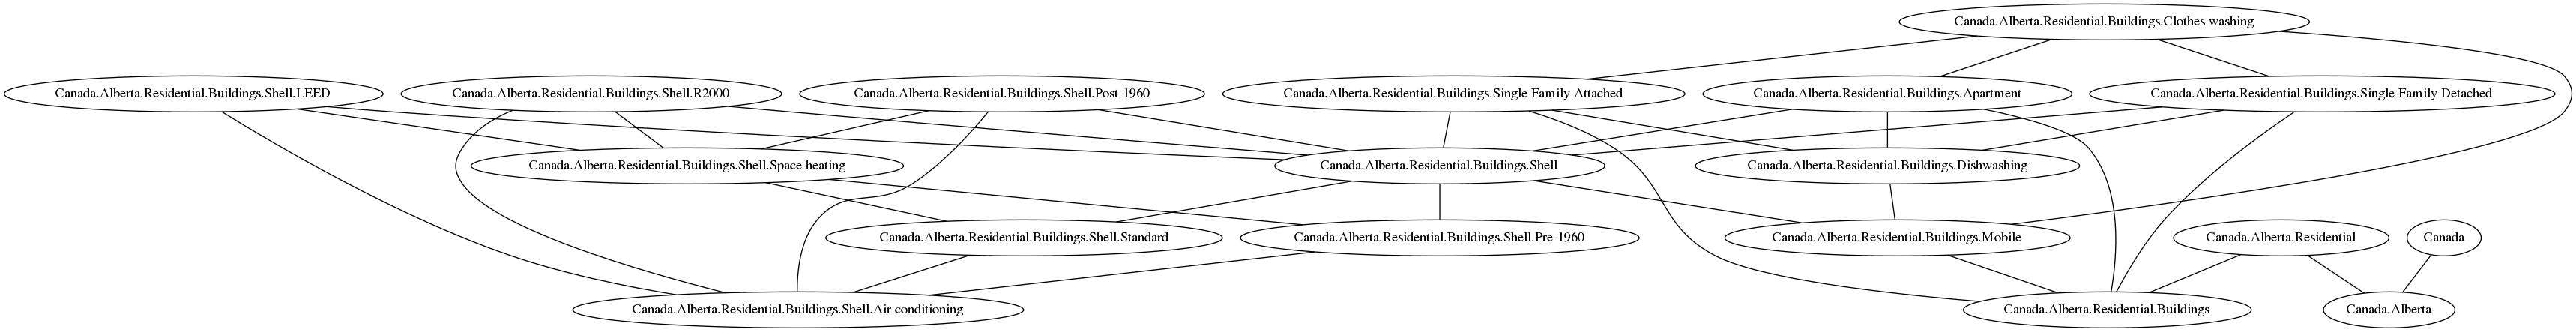

### Graph Component 1

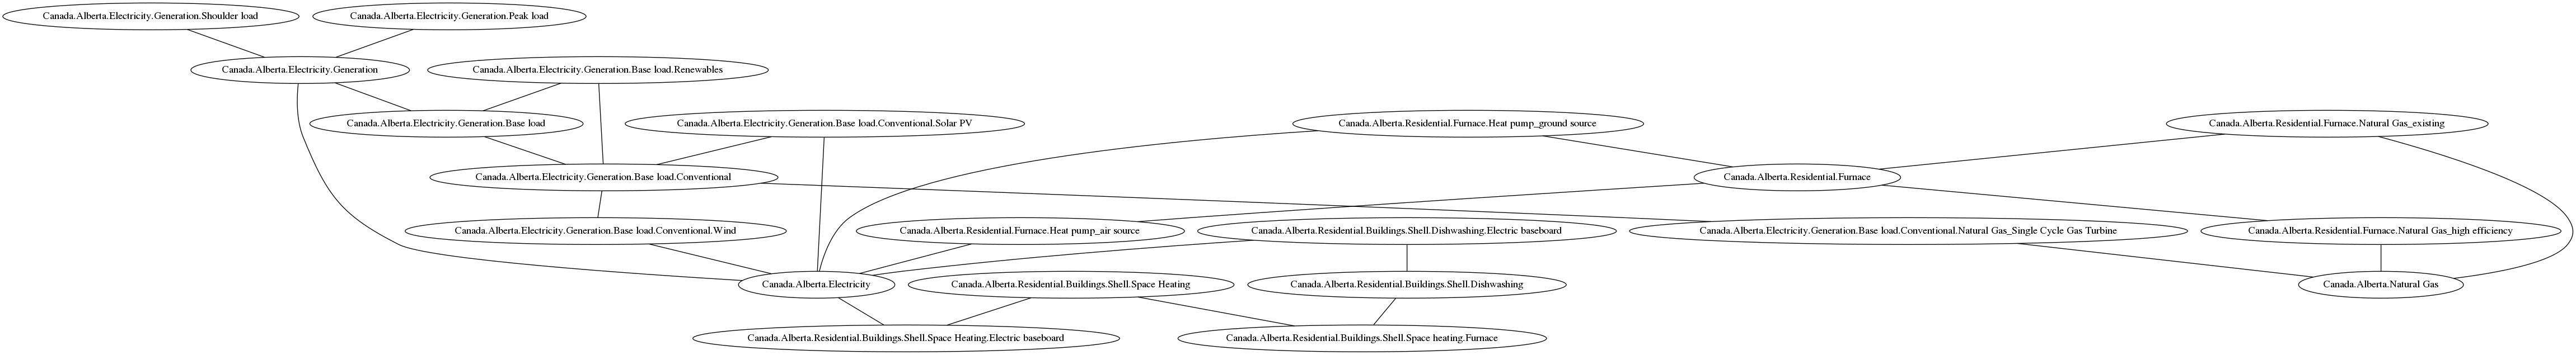

### Graph Component 2

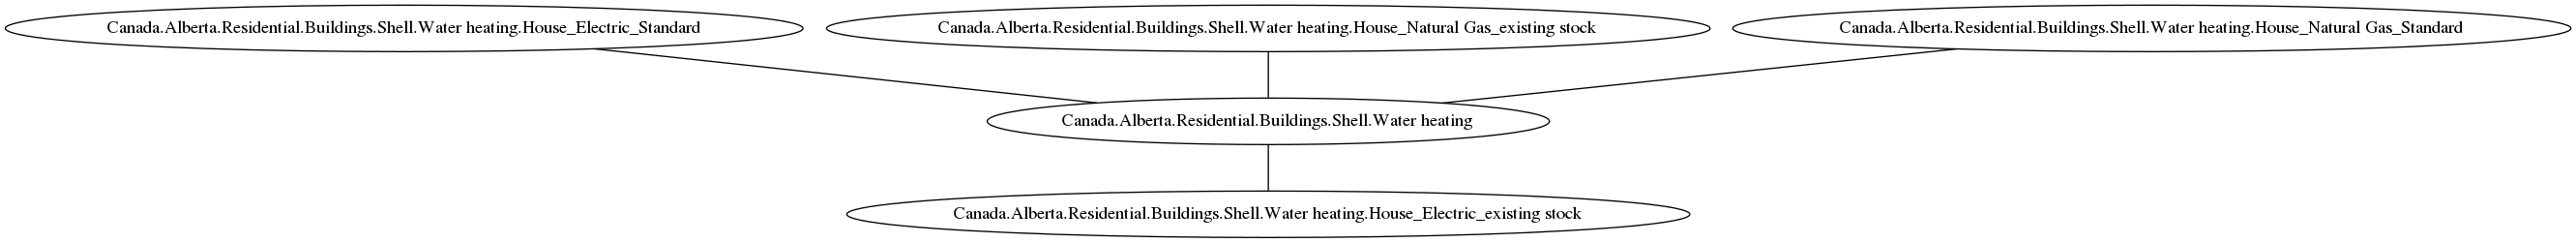

In [17]:
#with open("whole-graph.png","wb") as fh:
#    fh.write(to_pdot(G).create_png())

for k, C in enumerate(nx.connected_component_subgraphs(G)):
    pdot = to_pdot(C)
    display(Markdown("### Graph Component {}".format(k)))
    view_pydot(pdot, width=1600)